In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
import quantstats

pd.set_option('display.float_format', '{:.2f}'.format)


# dataframe

In [126]:
# 資料DataFrame
df = yfin.download('^TWII', start = '2018-1-1', end = '2018-12-31')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']


[*********************100%%**********************]  1 of 1 completed


# function

In [127]:
def get_llt(df, a):
    llt = np.zeros(len(df))
    llt[0] = df['close'].iloc[0]
    llt[1] = (1 - a) * df['close'].iloc[0] + a * df['close'].iloc[1]
    for n in range(2, len(df)):
        llt[n] = ((a - (a ** 2)/4) * df['close'].iloc[n]) + (((a ** 2)/2) * df['close'].iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * df['close'].iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    
    df['llt'] = llt
    df['llt_slope'] = np.nan

    for i in range(0, len(df)):
        df.loc[df.index[i], 'llt_slope'] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
    return df


def bolinger_band(df, p, q, rolling, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q, rescale = False)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = rolling).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = rolling).mean()

    df = get_middle(df)

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['llt']) / df['llt']
    df['lower_deviation'] = (df['llt'] - df['bolinger_lower']) / df['llt']

    df['upper_rise'] = df['upper_deviation'] >= upper_threshold
    df['lower_down'] = df['lower_deviation'] >= lower_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_u_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_l_threshold

    return df

def get_middle(df):
    
    df['middle'] = np.nan
    df.loc[df.index[0], 'middle'] = df['close'].iloc[0]

    for i in range(1, len(df)):

        upper_change = abs(df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1])
        lower_change = abs(df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1])
        
        peak_upward = upper_change > lower_change
        peak_downward = upper_change < lower_change
    
        if peak_upward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_lower_smooth'].iloc[i]) / (i + 1)
        elif peak_downward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_upper_smooth'].iloc[i]) / (i + 1)
    
    return df



# strategy

## long & short


In [128]:
def llt_strategy(df, feePaid, a, p, q, num_vol, rolling, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold, deviation_threshold, distance_threshold, drawdown):
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    highest, trailing_stop = 0, 0
    df['Bull'], ret_df['Bull'], equity['Bull'] = False, False, False
    df['Bear'], ret_df['Bear'], equity['Bear'] = False, False, False
    df['Consolidation'], ret_df['Consolidation'], equity['Consolidation'] = False, False, False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        hold_duration = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        distance_llt_upper = abs(df['llt'].iloc[i] - df['bolinger_upper_smooth'].iloc[i])
        distance_llt_lower = abs(df['llt'].iloc[i] - df['bolinger_lower_smooth'].iloc[i])
        
        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = ((df['bolinger_upper'].iloc[i] < df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition4) | ((df['bolinger_lower'].iloc[i] < df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition6)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = ((df['bolinger_upper'].iloc[i] > df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition3) | ((df['bolinger_lower'].iloc[i] > df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition5)
        entryLong_c = distance_llt_lower <= distance_threshold and distance_llt_lower <= distance_llt_upper
        entryShort_c = distance_llt_upper <= distance_threshold and distance_llt_upper <= distance_llt_lower

        exitLong_c = df['close'].iloc[i] <= trailing_stop
        exitShort_c = df['close'].iloc[i] >= trailing_stop

        df.at[df.index[i], 'Consolidation'] = (df['upper_deviation'].iloc[i] < deviation_threshold) & (df['lower_deviation'].iloc[i] < deviation_threshold)
        ret_df.loc[df['Consolidation'] == True, 'Consolidation'] = True
        equity.loc[df['Consolidation'] == True, 'Consolidation'] = True
        
        if df['Consolidation'].iloc[i] == False:
            df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
            df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)
            

        ret_df.loc[df['Bull'] == True, 'Bull'] = True
        equity.loc[df['Bull'] == True, 'Bull'] = True
        ret_df.loc[df['Bear'] == True, 'Bear'] = True
        equity.loc[df['Bear'] == True, 'Bear'] = True

        if BS == None:
            if df['Consolidation'].iloc[i]:
                if entryLong_c:
                    BS = 'B'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 - drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

                elif entryShort_c:
                    BS = 'S'
                    highest = df['open'].iloc[t]
                    trailing_stop = highest * (1 + drawdown)
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1
            elif df['Bull'].iloc[i]:
                if entryLong:
                    BS = 'B'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

            elif df['Bear'].iloc[i]:
                if entryShort:
                    BS = 'S'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1

        elif BS == 'B':
            if df['Consolidation'].iloc[i]:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if df['close'].iloc[i] > highest:
                    highest = df['open'].iloc[i]
                    trailing_stop = highest * (1 - drawdown)

                if exitLong_c:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None
                    highest, trailing_stop = 0, 0
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
            else:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if exitLong:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            if df['Consolidation'].iloc[i]:
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if df['close'].iloc[i] < highest:
                    highest = df['open'].iloc[i]
                    trailing_stop = highest * (1 + drawdown)

                if exitShort_c:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] += 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
                    highest, trailing_stop = 0, 0
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] += unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                        BS = None

                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
            else:            
                ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
                profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
                ret_df.at[ret_df.index[i], 'profit_list'] = profit

                if exitShort:
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    profit_fee = profit - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'position'] += 1
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None

                    profit_fee_realized = pl_round - feePaid * 2
                    ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

                elif i == len(df) - 2:
                    if ret_df['position'].iloc[len(df) - 2] != 0:
                        unit = ret_df['position'].iloc[len(df) - 2]
                        profit_fee = profit - feePaid * 2
                        pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                        ret_df.at[ret_df.index[i + 1], 'position'] += unit
                        ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                        ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                        ret_df.at[ret_df.index[i + 1], 'hold_duration'] = pd.date_range(start = ret_df.index[t], end = ret_df.index[i], freq = 'B').size
                        ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                        BS = None
                else:
                    profit_fee = profit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
                
    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return df, ret_df, equity

# parametors

In [129]:
a = 0.5
p = 1
q = 1
num_vol = 1
rolling = 20
upper_threshold = 0.04
lower_threshold = 0.04
retrace_u_threshold = 0.07
retrace_l_threshold = 0.07
deviation_threshold = 0.037
distance_threshold = 0.035
drawdown = 0.035
fund = 1000000
feePaid = 600

In [130]:

df, ret_df, equity = llt_strategy(
df, feePaid = feePaid, a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,
upper_threshold = upper_threshold, lower_threshold = lower_threshold,
retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold,
deviation_threshold = deviation_threshold, distance_threshold = distance_threshold, drawdown = drawdown
)

# df.to_csv('df.csv')
# ret_df.to_csv('ret_df.csv')

In [131]:
'''
df, ret_df, equity = consolidation_strategy(
df, feePaid = feePaid, a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,
upper_threshold = upper_threshold, lower_threshold = lower_threshold,
retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold,
deviation_threshold = deviation_threshold, distance_threshold = distance_threshold, drawdown = drawdown
)
'''

'\ndf, ret_df, equity = consolidation_strategy(\ndf, feePaid = feePaid, a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,\nupper_threshold = upper_threshold, lower_threshold = lower_threshold,\nretrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold,\ndeviation_threshold = deviation_threshold, distance_threshold = distance_threshold, drawdown = drawdown\n)\n'

## 指數

In [132]:
ret_df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    ret_df.loc[ret_df.index[i], 'index_ret'] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

ret_df['cum_index_ret'] = ret_df['index_ret'].cumsum()

# performance

In [133]:
bull_ret_df = ret_df[ret_df['Bull'] == True]
bear_ret_df = ret_df[ret_df['Bear'] == True]
consolidation_ret_df = ret_df[ret_df['Consolidation'] == True]
bull_equity = equity[equity['Bull'] == True]
bear_equity = equity[equity['Bear'] == True]
consolidation_equity = equity[equity['Consolidation'] == True]

no_c_ret_df = ret_df[ret_df['Consolidation'] == False]
no_c_equity = equity[equity['Consolidation'] == False]

In [134]:
ret_df

,Bull,Bear,Consolidation,position,buy,sell,sellshort,buytocover,buy_price,sell_price,...,buy_time,sell_time,sellshort_time,buytocover_time,hold_duration,profit_list,profit_fee_list,profit_fee_list_realized,index_ret,cum_index_ret
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,False,False,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,0.00,0.00,0.00,0.00,0.00
2018-01-03,False,False,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,0.00,0.00,0.00,18958.01,18958.01
2018-01-04,False,False,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,0.00,0.00,0.00,14993.95,33951.95
2018-01-05,False,False,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,0.00,0.00,0.00,4467.97,38419.92
2018-01-08,False,False,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,0.00,0.00,0.00,8433.98,46853.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,False,True,False,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,17366.02,17366.02,0.00,-490.04,-203658.01
2018-12-25,False,True,False,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,2966.02,2966.02,0.00,-17366.02,-221024.02
2018-12-26,False,True,False,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaT,NaT,NaT,NaT,NaN,-2027.93,-2027.93,0.00,-2966.02,-223990.04


## Total performance

In [135]:
def get_performance(ret_df, equity):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum()) + min((ret_df['sellshort'] > 0).sum(), (ret_df['buytocover'] > 0).sum())
    average_holding_duration = ret_df['hold_duration'].sum() / tradeTimes
    winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = ret_df['profit_list'].mean()
    std_ret = ret_df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    print('Duration : ', duration, 'days')
    print('Average holding duration', average_holding_duration, 'days')
    print('Profit : ', profit)
    print('Return : ', ret)
    print('Max DrawDown : ', mdd)
    print('Caimar Ratio : ', calmarRatio)
    print('Trade Times : ', tradeTimes)
    print('Win Rate : ', winRate)
    print('Profit Factor : ', profitFactor)
    print('Sharp Ratio : ', sharp)

print('------------------------------Total----------------------------------')
get_performance(ret_df, equity)
print('------------------------------Consolidation----------------------------------')
get_performance(consolidation_ret_df, consolidation_equity)
print('------------------------------Bull & Bear----------------------------------')
get_performance(no_c_ret_df, no_c_equity)

------------------------------Total----------------------------------
Duration :  360 days
Average holding duration 9.833333333333334 days
Profit :  -49200.1953125
Return :  -0.04920019531249997
Max DrawDown :  0.16420125674885644
Caimar Ratio :  -0.2996334881148382
Trade Times :  6
Win Rate :  0.16666666666666666
Profit Factor :  0.5699668754976857
Sharp Ratio :  -0.01703485836300396
------------------------------Consolidation----------------------------------
Duration :  277 days
Average holding duration inf days
Profit :  -53175.9765625
Return :  -0.05317597656249995
Max DrawDown :  0.05317597656249995
Caimar Ratio :  -1.0
Trade Times :  0
Win Rate :  nan
Profit Factor :  0.0
Sharp Ratio :  0.07474239155688445
------------------------------Bull & Bear----------------------------------
Duration :  360 days
Average holding duration 10.0 days
Profit :  -49200.1953125
Return :  -0.04920019531249997
Max DrawDown :  0.16420125674885644
Caimar Ratio :  -0.2996334881148382
Trade Times :  5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_12747/822946627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['equity'] = equity['profitfee'] + fund
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_12747/822946627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_12747/822946627.py:6: SettingWithCopyWarning: 
A value is trying to be set 

# plot

## profit

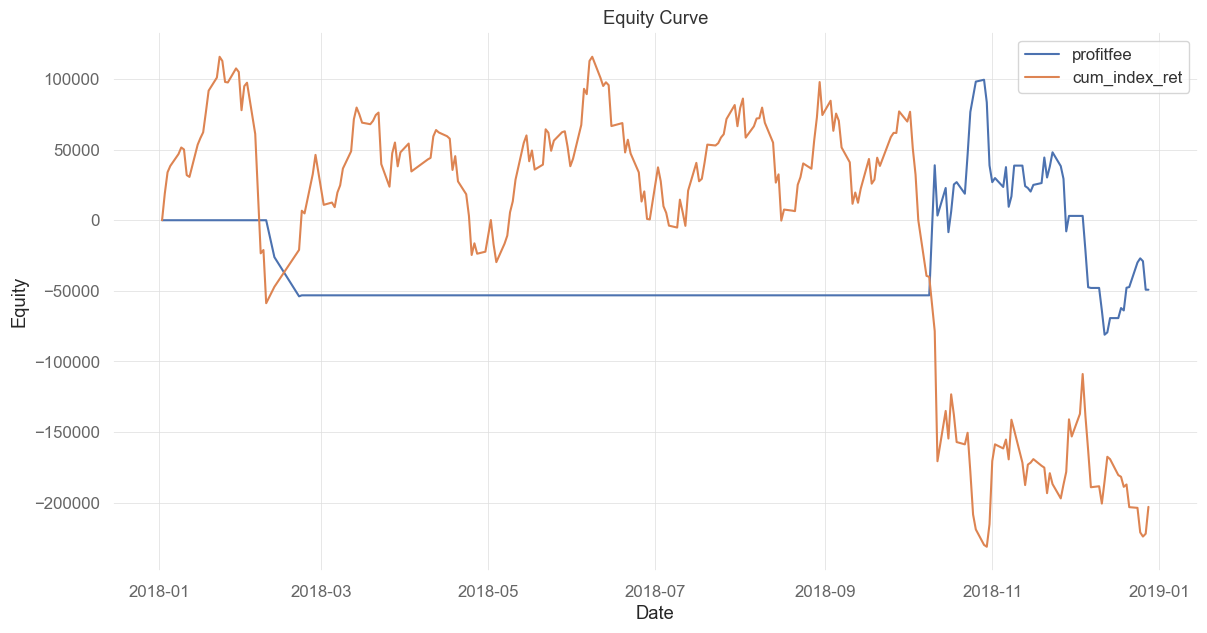

In [136]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, ret_df['cum_index_ret'], label='cum_index_ret')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


## 買賣點

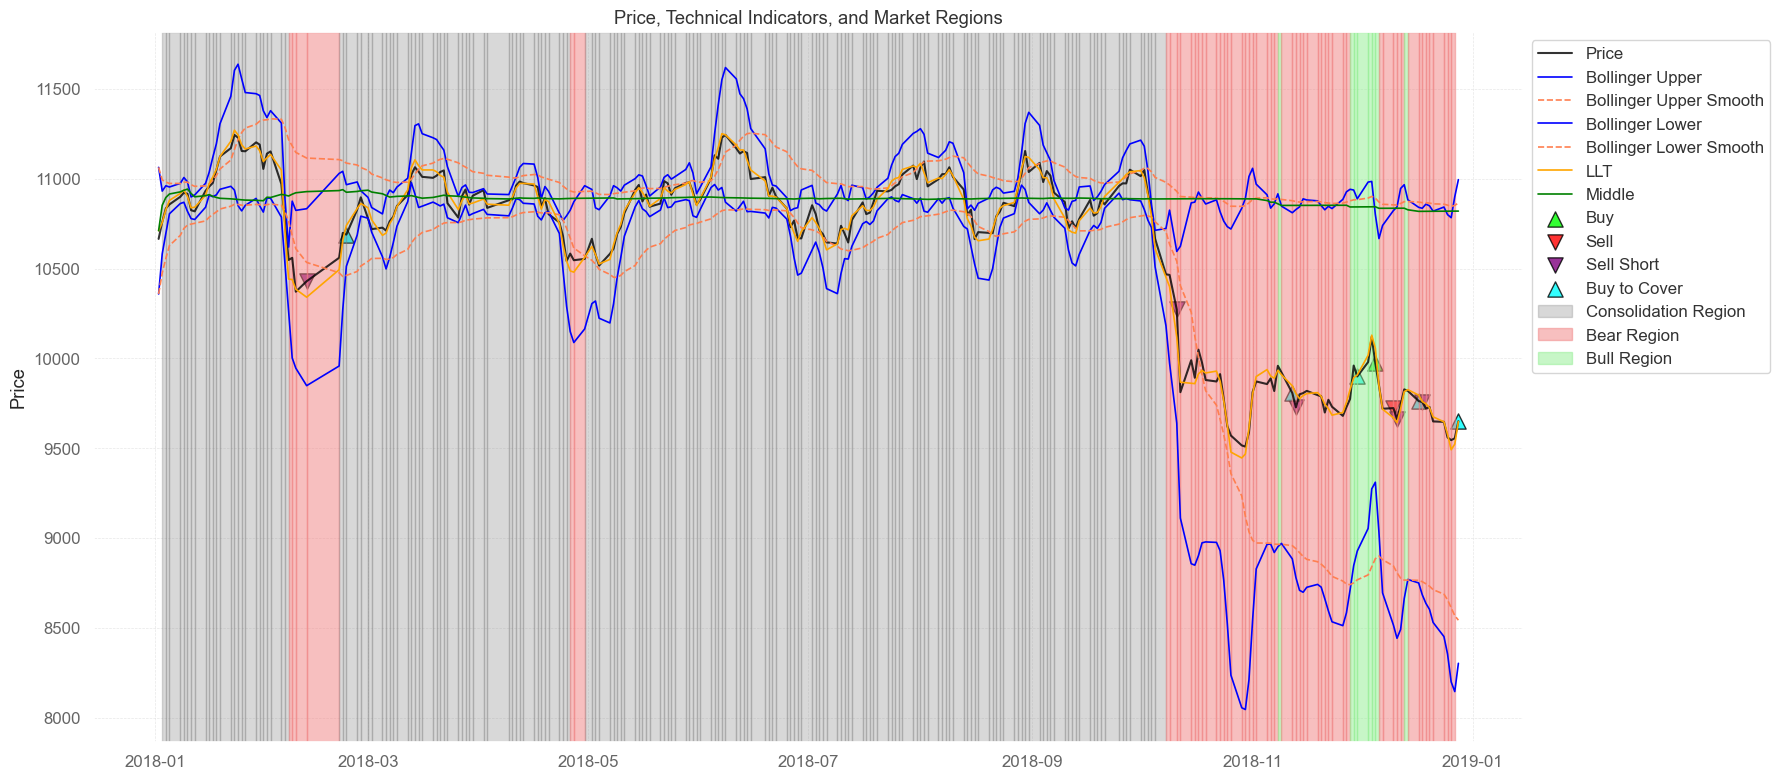

In [137]:
buy_points = ret_df[ret_df['buy'] > 0]
sell_points = ret_df[ret_df['sell'] > 0]
sellshort_points = ret_df[ret_df['sellshort'] > 0]
buytocover_points = ret_df[ret_df['buytocover'] > 0]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharex=True)

ax1.plot(df.index, df['open'], label='Price', color='black', alpha=0.8, linewidth=1.5)

ax1.plot(df.index, df['bolinger_upper'], label='Bollinger Upper', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['bolinger_lower'], label='Bollinger Lower', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['llt'], label='LLT', color='orange', linewidth=1.2)
ax1.plot(df.index, df['middle'], label='Middle', color='green', linewidth=1.2)

ax1.scatter(buy_points.index, df['open'].loc[buy_points.index], color='lime', edgecolor='black', marker='^', label='Buy', s=120, alpha=0.8)
ax1.scatter(sell_points.index, df['open'].loc[sell_points.index], color='red', edgecolor='black', marker='v', label='Sell', s=120, alpha=0.8)
ax1.scatter(sellshort_points.index, df['open'].loc[sellshort_points.index], color='purple', edgecolor='black', marker='v', label='Sell Short', s=120, alpha=0.8)
ax1.scatter(buytocover_points.index, df['open'].loc[buytocover_points.index], color='cyan', edgecolor='black', marker='^', label='Buy to Cover', s=120, alpha=0.8)

## 畫趨勢區域
bull_region_label_shown = False
bear_region_label_shown = False
consolidation_region_label_shown = False
for i in range(1, len(df)):
    if df['Bull'].iloc[i]:
        ax1.axvspan(df.index[i-1], df.index[i], color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
        bull_region_label_shown = True
    if df['Bear'].iloc[i]:
        ax1.axvspan(df.index[i-1], df.index[i], color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
        bear_region_label_shown = True
    if df['Consolidation'].iloc[i]:
        ax1.axvspan(df.index[i-1], df.index[i], color='gray', alpha=0.3, label='Consolidation Region' if not consolidation_region_label_shown else "")
        consolidation_region_label_shown = True

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title('Price, Technical Indicators, and Market Regions')
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [138]:
# 确保状态互斥
ret_df['bull_bear_consolidation_check'] = (
    ret_df[['Bull', 'Bear', 'Consolidation']].sum(axis=1) > 1
)

# 打印违反互斥规则的行
print(ret_df[ret_df['bull_bear_consolidation_check']])

# 修正：根据优先级调整状态
ret_df.loc[(ret_df['Bull'] & ret_df['Consolidation']), 'Consolidation'] = False
ret_df.loc[(ret_df['Bear'] & ret_df['Consolidation']), 'Consolidation'] = False


Empty DataFrame
Columns: [Bull, Bear, Consolidation, position, buy, sell, sellshort, buytocover, buy_price, sell_price, short_price, buytocover_price, buy_time, sell_time, sellshort_time, buytocover_time, hold_duration, profit_list, profit_fee_list, profit_fee_list_realized, index_ret, cum_index_ret, bull_bear_consolidation_check]
Index: []

[0 rows x 23 columns]


## performance

/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2018-12-28
Risk-Free Rate             0.0%
Time in Market             22.0%

Cumulative Return          -4.92%
CAGR﹪                     -3.48%

Sharpe                     -0.24
Prob. Sharpe Ratio         40.71%
Smart Sharpe               -0.23
Sortino                    -0.37
Smart Sortino              -0.35
Sortino/√2                 -0.27
Smart Sortino/√2           -0.25
Omega                      0.91

Max Drawdown               -16.42%
Longest DD Days            240
Volatility (ann.)          16.11%
Calmar                     -0.21
Skew                       2.85
Kurtosis                   37.57

Expected Daily %           -0.02%
Expected Monthly %         -0.42%
Expected Yearly %          -4.92%
Kelly Criterion            -5.22%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.68%
Expected Shortfall (cVaR)  -1.68%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-30,2018-12-12,2018-12-28,60,-16.42,-16.27
2,2018-02-12,2018-02-21,2018-10-09,240,-5.39,-2.61
3,2018-10-12,2018-10-16,2018-10-22,11,-4.56,-3.43


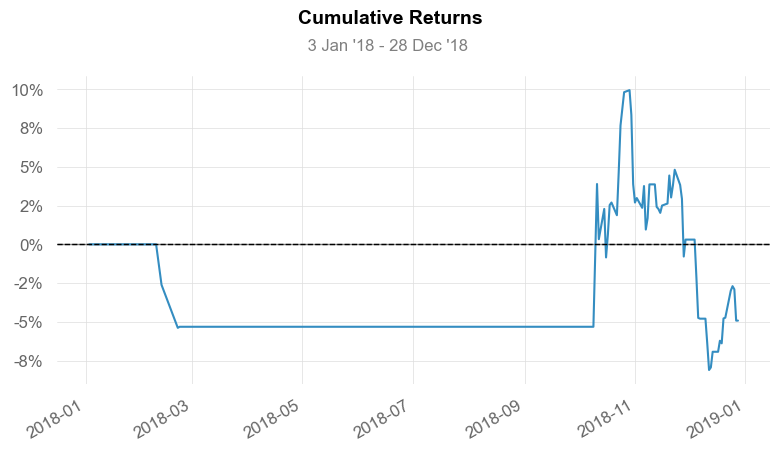

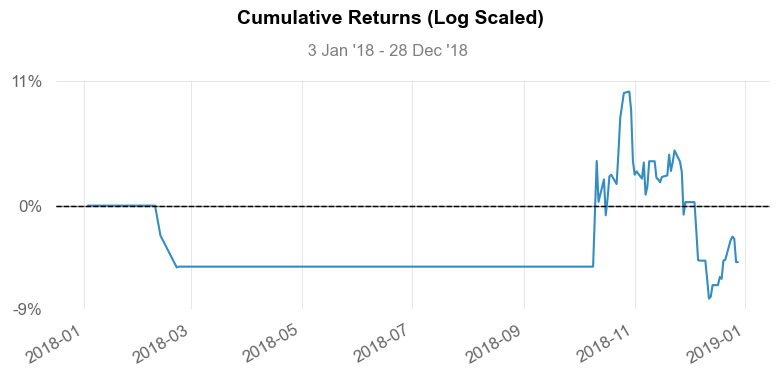

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


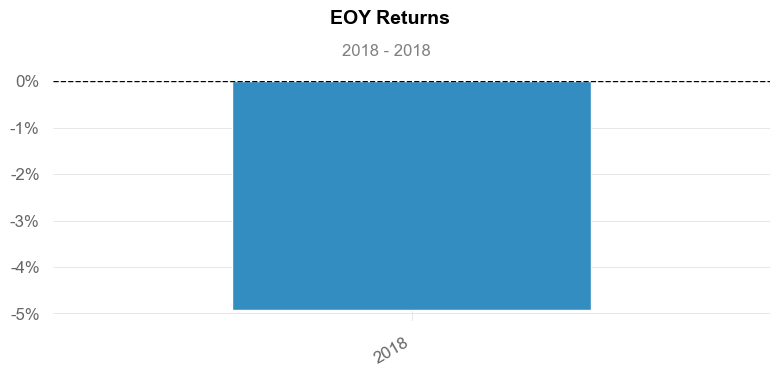

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


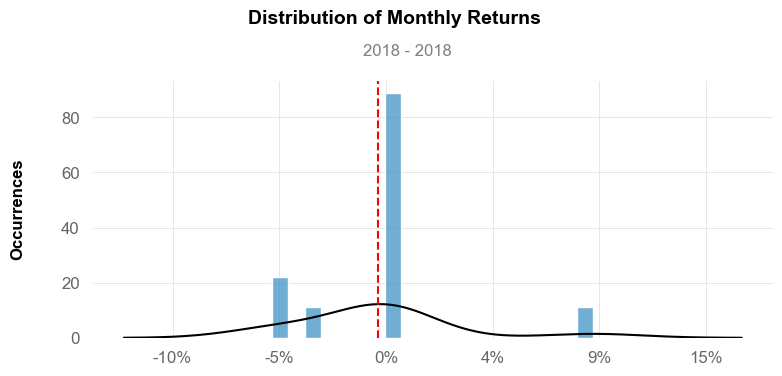

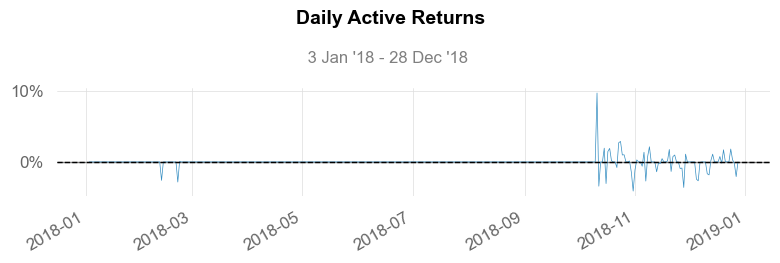

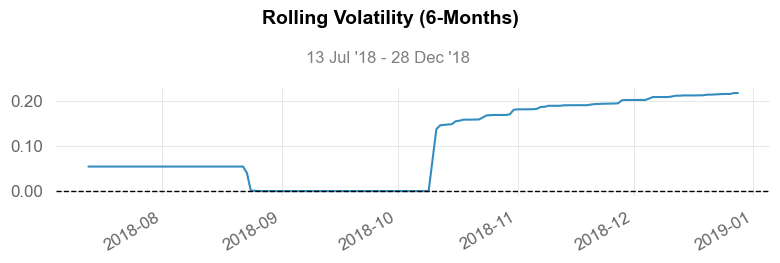

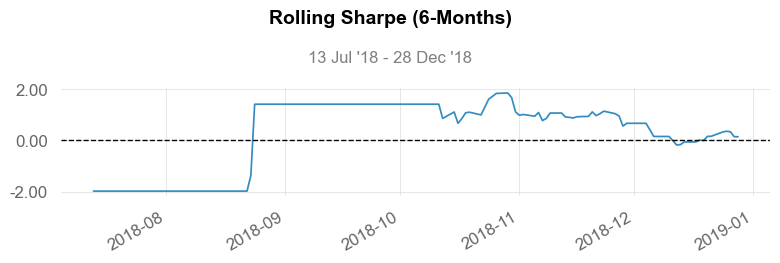

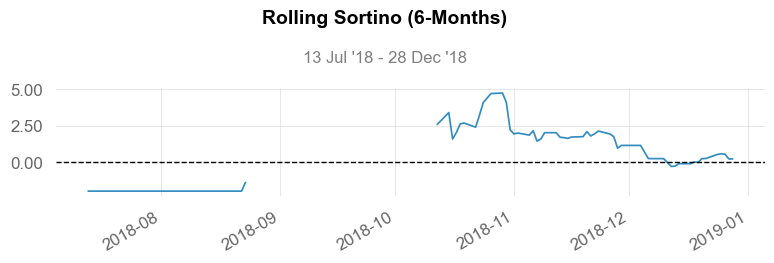

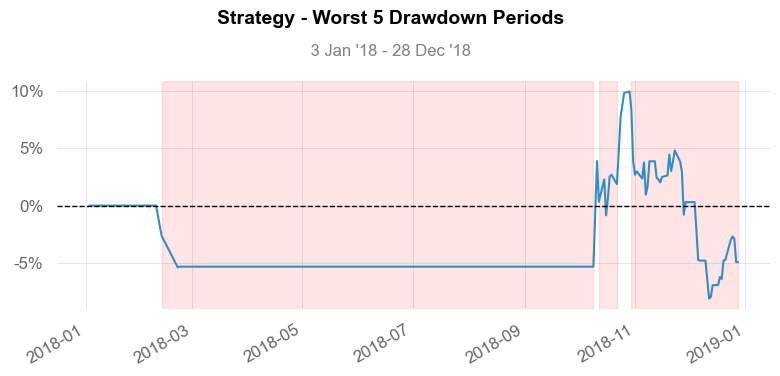

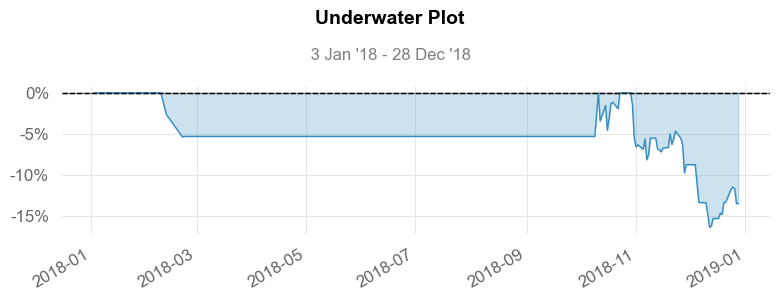

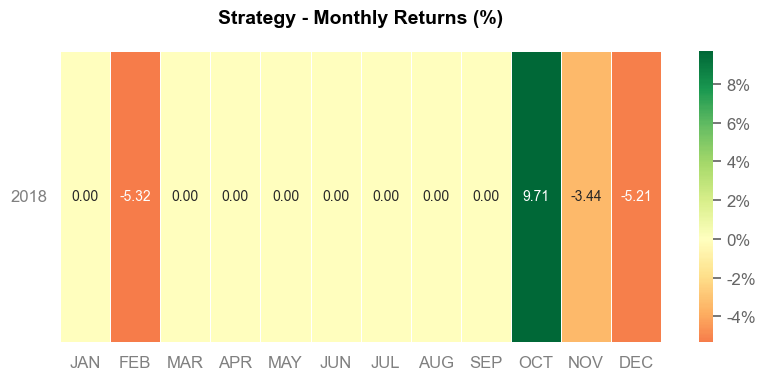

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1019: FutureWarni

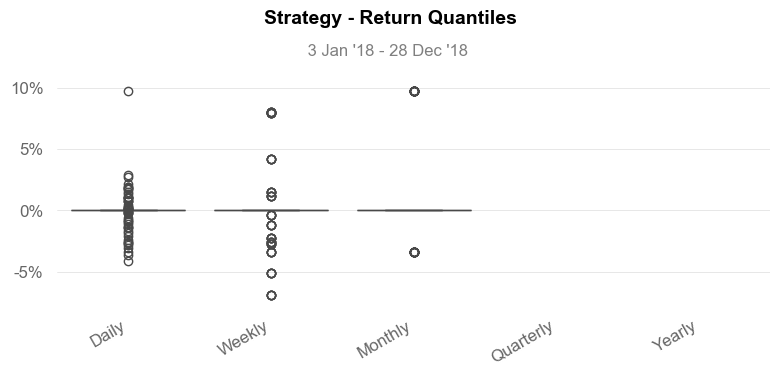

In [139]:
ret = equity['equity'].pct_change(periods=1).dropna()
quantstats.reports.full(ret)

In [140]:
df.to_csv('df.csv')
ret_df.to_csv('ret_df.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'df.csv'